In [23]:
%pylab inline --no-import-all

import pandas as pd
import numpy as np

pd.options.display.max_columns=50

Populating the interactive namespace from numpy and matplotlib


## Load data

# Data Visualization

In [65]:
# Data is assumed to be in directory data/
columns_names_dict = {"fecha_dato": "FETCH_DATE", "ncodpers": "CUST_ID", "ind_empleado": "EMPLYMT_STATUS", "pais_residencia": "RESID_CNTRY", "sexo": "CUST_SEX", "age": "CUST_AGE", "fecha_alta": "FSTHOLD_DATE", "ind_nuevo": "NEW_CUST", "antiguedad": "SENIORITY_MNTH", "indrel": "PRMRY_CUST", "ult_fec_cli_1t": "PRMRY_LASTDATE", "indrel_1mes": "CUST_TYPE", "tiprel_1mes": "CUST_ACTVTY", "indresi": "RESID_IDX", "indext": "FOREIGN_IDX", "conyuemp": "SPOUSE_EMP", "canal_entrada": "JOIN_CNL", "indfall": "DECEASED", "tipodom": "RESID_TYPE", "cod_prov": "RESID_ADD_CD", "nomprov": "RESID_ADD_NM", "ind_actividad_cliente": "CUST_ACTIVE", "renta": "CUST_HOUS_INCOM", "segmento": "CUST_SEGMNT", "ind_ahor_fin_ult1": "ACCNT_SAVIN", "ind_aval_fin_ult1": "ACCNT_GARNT", "ind_cco_fin_ult1": "ACCNT_CURNT", "ind_cder_fin_ult1": "ACCNT_DERIV", "ind_cno_fin_ult1": "ACCNT_PAYRL", "ind_ctju_fin_ult1": "ACCNT_JUNIO", "ind_ctma_fin_ult1": "ACCNT_MASPT", "ind_ctop_fin_ult1": "ACCNT_PARTI", "ind_ctpp_fin_ult1": "ACCNT_PARTP", "ind_deco_fin_ult1": "ACCNT_STDEP", "ind_deme_fin_ult1": "ACCNT_MTDEP", "ind_dela_fin_ult1": "ACCNT_LTDEP", "ind_ecue_fin_ult1": "ACCNT_EACCN", "ind_fond_fin_ult1": "ACCNT_FUNDS", "ind_hip_fin_ult1": "ACCNT_MORTG", "ind_plan_fin_ult1": "ACCNT_PENSN", "ind_pres_fin_ult1": "ACCNT_LOANS", "ind_reca_fin_ult1": "ACCNT_TAXES", "ind_tjcr_fin_ult1": "ACCNT_CCARD", "ind_valo_fin_ult1": "ACCNT_SECUR", "ind_viv_fin_ult1": "ACCNT_HOMEA", "ind_nomina_ult1": "PAYROLL", "ind_nom_pens_ult1": "PENSIONS", "ind_recibo_ult1": "DIRECTDEBT"}
data_train = pd.read_csv("data/train_ver2.csv", parse_dates=[0,6], nrows=100000)
data_train.rename(columns=columns_names_dict, inplace=True)



# Convert "CUST_AGE" to int (from string)
data_train["CUST_AGE"].replace(' NA', '0', inplace = True)
data_train["CUST_AGE"] = map(int, data_train["CUST_AGE"])
data_train.head()


,FETCH_DATE,CUST_ID,EMPLYMT_STATUS,RESID_CNTRY,CUST_SEX,CUST_AGE,FSTHOLD_DATE,NEW_CUST,SENIORITY_MNTH,PRMRY_CUST,PRMRY_LASTDATE,CUST_TYPE,CUST_ACTVTY,RESID_IDX,FOREIGN_IDX,SPOUSE_EMP,JOIN_CNL,DECEASED,RESID_TYPE,RESID_ADD_CD,RESID_ADD_NM,CUST_ACTIVE,CUST_HOUS_INCOM,CUST_SEGMNT,ACCNT_SAVIN,ACCNT_GARNT,ACCNT_CURNT,ACCNT_DERIV,ACCNT_PAYRL,ACCNT_JUNIO,ACCNT_MASPT,ACCNT_PARTI,ACCNT_PARTP,ACCNT_STDEP,ACCNT_MTDEP,ACCNT_LTDEP,ACCNT_EACCN,ACCNT_FUNDS,ACCNT_MORTG,ACCNT_PENSN,ACCNT_LOANS,ACCNT_TAXES,ACCNT_CCARD,ACCNT_SECUR,ACCNT_HOMEA,PAYROLL,PENSIONS,DIRECTDEBT
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaN,1.0,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


## Age histogram

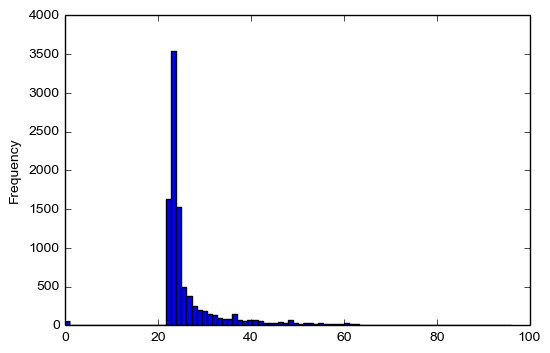

In [70]:
data_train["CUST_AGE"].plot.hist(bins = len(data_train["CUST_AGE"].unique()))